In [1]:
# import
import pandas as pd
import sqlite3
import numpy as np
import re
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

versions_v2_03091448

# Table of content:

- ## [Functions](#Functions)
- ## [Joining](#Joining):
    - [Strategy](#Strategy)
    - [Feature engineering](#feature-engineering):
        - [Create meaningful columns](#create-meaningful-columns)
        - [Cleaning dataframe](#cleaning-dataframe)
        - [Missing values](#missing-values)

- ## [Database](#Database):

Acronyms and Definition:

+ fsq = FourSquare (API)
+ yelp = Yelp (API)
+ poi(s) = Point Of Interest(s)
+ stations = Bike rental station (Bixi - Montréal, Qc, Canada)

## Functions

In [2]:
# Function to rename columns in a DataFrame
def rename_columns(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)

## Joining

In [3]:
# Load data from sources
stations = pd.read_csv('../data/stations.csv', index_col=None)
fsq_pois = pd.read_csv('../data/fsq_businesses.csv', index_col=None)
yelp_pois = pd.read_csv('../data/yelp_businesses.csv', index_col=None)

### Strategy

- Create a combined dataframe with both Yelp and FourSquare data for the creation of the SQLite database.
<br>See [Database](#Database) section.
- Filter the combined date with Yelp API only for the first model, and both for the second model.

### Feature engineering

#### Create meaningful columns

In [4]:
# Change some columns name to match both data
# FSQ
fsq_rename_dict = {
    'fsq_id': 'api_number'
}

# Yelp:
yelp_rename_dict = {
    'id': 'api_number',
    'category_alias': 'category_name',
    'rating': 'original_rating',
    'scaled_rating': 'rating'
}

# Apply rename_columns to both DataFrames
rename_columns(fsq_pois, fsq_rename_dict)
rename_columns(yelp_pois, yelp_rename_dict)

In [5]:
# Create api_name to differentiate the POI provenance and api_number
fsq_pois['api_name'] = "FourSquare"
yelp_pois['api_name'] = "Yelp"

In [6]:
# Create POI id for easier reference using the rank method to assign unique integers to each unique api_number

# Yelp:
yelp_pois['poi_id'] = yelp_pois['api_number'].rank(method='dense').astype(int) - 1 # start from 0

# Register the last poi_id
starting_number = yelp_pois['poi_id'].max()

# FSQ:
fsq_pois['poi_id'] = fsq_pois['api_number'].rank(method='dense').astype(int) + starting_number

In [7]:
# Validate
print(starting_number)
print(yelp_pois['poi_id'].sort_values().tail(1))
print(fsq_pois['poi_id'].sort_values().head(1))

2424
1527    2424
Name: poi_id, dtype: int64
34100    2425
Name: poi_id, dtype: int64


In [8]:
yelp_pois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22394 entries, 0 to 22393
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   api_number       22394 non-null  object 
 1   name             22394 non-null  object 
 2   original_rating  22394 non-null  float64
 3   price            17393 non-null  float64
 4   review_count     22394 non-null  int64  
 5   s_lat            22394 non-null  float64
 6   s_lon            22394 non-null  float64
 7   p_lat            22394 non-null  float64
 8   p_lon            22394 non-null  float64
 9   category_name    22394 non-null  object 
 10  distance         22394 non-null  int64  
 11  rating           22394 non-null  float64
 12  station          22394 non-null  int64  
 13  api_name         22394 non-null  object 
 14  poi_id           22394 non-null  int64  
dtypes: float64(7), int64(4), object(4)
memory usage: 2.6+ MB


In [9]:
fsq_pois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59349 entries, 0 to 59348
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   api_number     59349 non-null  object 
 1   name           59349 non-null  object 
 2   s_lat          59349 non-null  float64
 3   s_lon          59349 non-null  float64
 4   p_lat          59349 non-null  float64
 5   p_lon          59349 non-null  float64
 6   category_id    59349 non-null  int64  
 7   category_name  59349 non-null  object 
 8   distance       59349 non-null  int64  
 9   rating         39961 non-null  float64
 10  popularity     51230 non-null  float64
 11  price          43531 non-null  float64
 12  station        59349 non-null  int64  
 13  api_name       59349 non-null  object 
 14  poi_id         59349 non-null  int64  
dtypes: float64(7), int64(4), object(4)
memory usage: 6.8+ MB


In [10]:
yelp_pois.head()

,api_number,name,original_rating,price,review_count,s_lat,s_lon,p_lat,p_lon,category_name,distance,rating,station,api_name,poi_id
0,vRJPrk-VH75uxLiVVprBhA,Capucine,5.0,NaN,4,45.6175,-73.606011,45.619670,-73.609704,italian,375,10.00,790,Yelp,2243
1,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3.0,14,45.6175,-73.606011,45.617234,-73.594176,italian,921,7.75,790,Yelp,1136
2,TyKGLi1V1PFRHYmHDjFUMQ,Restaurant Prima Luna,4.0,3.0,14,45.6175,-73.606011,45.617234,-73.594176,sushi,921,7.75,790,Yelp,1136
3,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,italian,366,7.75,790,Yelp,511
4,DOVOYnq3y-milXVI03GIrg,Boulangerie Adriatica,4.0,NaN,1,45.6175,-73.606011,45.615210,-73.609710,pizza,366,7.75,790,Yelp,511


In [11]:
fsq_pois.head()

,api_number,name,s_lat,s_lon,p_lat,p_lon,category_id,category_name,distance,rating,popularity,price,station,api_name,poi_id
0,4cb240b8cbab236ae154af73,Restaurant Prima Luna,45.6175,-73.606011,45.617439,-73.593995,13236,Italian Restaurant,941,7.4,0.985,1.0,790,FourSquare,4078
1,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,10039,Music Venue,19,NaN,0.969,NaN,790,FourSquare,4392
2,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,11130,Office Building,19,NaN,0.969,NaN,790,FourSquare,4392
3,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13034,Café,79,NaN,0.869,1.0,790,FourSquare,4519
4,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13035,Coffee Shop,79,NaN,0.869,1.0,790,FourSquare,4519


#### Missing values

As per our strategy, we need to do two models: one with the Yelp data only and one with the combined data.<br>
We will create columns to keep track of the changes.

In [12]:
# Create change_log columns
yelp_pois['price_change_log'] = 0

fsq_pois['rating_change_log'] = 0
fsq_pois['price_change_log'] = 0
fsq_pois['popularity_change_log'] = 0

# Identify missing value rows for Yelp
yelp_pois['price_change_log'] = np.where(yelp_pois['price'].isnull(), 1, 0)

fsq_pois['price_change_log'] = np.where(fsq_pois['price'].isnull(), 1, 0)
fsq_pois['rating_change_log'] = np.where(fsq_pois['price'].isnull(), 1, 0)
fsq_pois['popularity_change_log'] = np.where(fsq_pois['price'].isnull(), 1, 0)

In [13]:
# Validate one change
print(True if yelp_pois[yelp_pois['price_change_log'] == 1].shape[0] == yelp_pois[yelp_pois['price'].isnull()].shape[0] else False)

True


Yelp:<br>
- About 22% of prices are missing. Since it's an ordinal column (value betwenn 1 and 4) we will use the mode.<br>
(Note: if we had more time, we could try to identify the missing prices from FSQ, but even then we would not fill them completely)

FourSquare:<br>
- Abuot 27% of prices are missing. We could also apply the mode.
- About 32% of rating and 13% of popularity are missing. Applying the means will probably strongly biase the data.

In [14]:
# Get the modes
mode_price_yelp = yelp_pois['price'].mode()[0]
mode_price_fsq = fsq_pois['price'].mode()[0]

# Get the means
mean_rating_fsq = fsq_pois['rating'].mean()
mean_popularity_fsq = fsq_pois['popularity'].mean()
print(f"Modes:")
print(f"    Yelp =  {mode_price_yelp}")
print(f"    Foursquare =  {mode_price_fsq}")
print(f"FourSquare means:")
print(f"     Rating = {mean_rating_fsq:.3f}")
print(f"     Popularity = {mean_popularity_fsq:.3f}")

Modes:
    Yelp =  2.0
    Foursquare =  1.0
FourSquare means:
     Rating = 8.010
     Popularity = 0.900


In [15]:
# Fill missing values
yelp_pois['price'] = np.where(yelp_pois['price_change_log'], mode_price_yelp, yelp_pois['price'])

fsq_pois['price'] = np.where(fsq_pois['price_change_log'], mode_price_fsq, fsq_pois['price'])
fsq_pois['rating'] = np.where(fsq_pois['rating_change_log'], mean_rating_fsq, fsq_pois['rating'])
fsq_pois['popularity'] = np.where(fsq_pois['popularity_change_log'], mean_popularity_fsq, fsq_pois['popularity'])
print(yelp_pois.head())

               api_number                   name  original_rating  price  \
0  vRJPrk-VH75uxLiVVprBhA               Capucine              5.0    2.0   
1  TyKGLi1V1PFRHYmHDjFUMQ  Restaurant Prima Luna              4.0    3.0   
2  TyKGLi1V1PFRHYmHDjFUMQ  Restaurant Prima Luna              4.0    3.0   
3  DOVOYnq3y-milXVI03GIrg  Boulangerie Adriatica              4.0    2.0   
4  DOVOYnq3y-milXVI03GIrg  Boulangerie Adriatica              4.0    2.0   

   review_count    s_lat      s_lon      p_lat      p_lon category_name  \
0             4  45.6175 -73.606011  45.619670 -73.609704       italian   
1            14  45.6175 -73.606011  45.617234 -73.594176       italian   
2            14  45.6175 -73.606011  45.617234 -73.594176         sushi   
3             1  45.6175 -73.606011  45.615210 -73.609710       italian   
4             1  45.6175 -73.606011  45.615210 -73.609710         pizza   

   distance  rating  station api_name  poi_id  price_change_log  
0       375   10.00      7

In [16]:
print(yelp_pois.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22394 entries, 0 to 22393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   api_number        22394 non-null  object 
 1   name              22394 non-null  object 
 2   original_rating   22394 non-null  float64
 3   price             22394 non-null  float64
 4   review_count      22394 non-null  int64  
 5   s_lat             22394 non-null  float64
 6   s_lon             22394 non-null  float64
 7   p_lat             22394 non-null  float64
 8   p_lon             22394 non-null  float64
 9   category_name     22394 non-null  object 
 10  distance          22394 non-null  int64  
 11  rating            22394 non-null  float64
 12  station           22394 non-null  int64  
 13  api_name          22394 non-null  object 
 14  poi_id            22394 non-null  int64  
 15  price_change_log  22394 non-null  int64  
dtypes: float64(7), int64(5), object(4)
memor

In [17]:
# Saving dataframes
yelp_pois.to_csv('../data/yelp_pois.csv', index=False)
fsq_pois.to_csv('../data/fsq_pois.csv', index=False)

### Create combined dataframes

In [18]:
# Create combined dataframe
combined_df = pd.concat([fsq_pois, yelp_pois], keys=['fsq_pois', 'yelp_pois'], ignore_index=True)
combined_df.head()

,api_number,name,s_lat,s_lon,p_lat,p_lon,category_id,category_name,distance,rating,popularity,price,station,api_name,poi_id,rating_change_log,price_change_log,popularity_change_log,original_rating,review_count
0,4cb240b8cbab236ae154af73,Restaurant Prima Luna,45.6175,-73.606011,45.617439,-73.593995,13236.0,Italian Restaurant,941,7.400000,0.985000,1.0,790,FourSquare,4078,0.0,0,0.0,NaN,NaN
1,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,10039.0,Music Venue,19,8.009992,0.899922,1.0,790,FourSquare,4392,1.0,1,1.0,NaN,NaN
2,4e0b48221f6edc06be259aec,Salle Désilets,45.6175,-73.606011,45.617818,-73.606000,11130.0,Office Building,19,8.009992,0.899922,1.0,790,FourSquare,4392,1.0,1,1.0,NaN,NaN
3,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13034.0,Café,79,NaN,0.869000,1.0,790,FourSquare,4519,0.0,0,0.0,NaN,NaN
4,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,45.617214,-73.604961,13035.0,Coffee Shop,79,NaN,0.869000,1.0,790,FourSquare,4519,0.0,0,0.0,NaN,NaN


In [19]:
# Grouping the POIs per station with their characteristics

# Yelp only

grouped_yelp = (
    combined_df[combined_df['api_name'] == 'Yelp'][['station', 'distance', 'review_count', 'rating', 'price']]
    .groupby('station')
    .mean()
    .sort_values('station')
)
# Both API

grouped_df = (
    combined_df[['station', 'distance', 'review_count', 'rating', 'popularity', 'price']]
    .groupby('station')
    .mean()
    .sort_values('station')
)

In [20]:
grouped_yelp.head()

,distance,review_count,rating,price
station,,,,
0,262.976744,258.302326,8.063953,2.627907
1,451.472222,382.611111,8.468750,2.722222
2,458.270270,291.756757,8.297297,2.486486
3,640.600000,31.150000,6.962500,2.000000
4,237.250000,282.625000,8.087500,2.225000


In [21]:
# Merge with stations
merged_yelp = pd.merge(stations, grouped_yelp, on='station')
merged_df = pd.merge(stations, grouped_df, on='station')

In [22]:
merged_yelp.head()

,station_name,latitude,longitude,total_bikes,station,distance,review_count,rating,price
0,de la Commune / Place Jacques-Cartier,45.507610,-73.551836,78,0,262.976744,258.302326,8.063953,2.627907
1,de la Commune / King,45.497504,-73.552845,62,1,451.472222,382.611111,8.468750,2.722222
2,Jeanne-Mance / René-Lévesque,45.506371,-73.564201,55,2,458.270270,291.756757,8.297297,2.486486
3,Métro Viau (Viau / Pierre-de-Coubertin),45.563084,-73.548194,50,3,640.600000,31.150000,6.962500,2.000000
4,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070,48,4,237.250000,282.625000,8.087500,2.225000


In [23]:
merged_yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 0 to 794
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  795 non-null    object 
 1   latitude      795 non-null    float64
 2   longitude     795 non-null    float64
 3   total_bikes   795 non-null    int64  
 4   station       795 non-null    int64  
 5   distance      795 non-null    float64
 6   review_count  795 non-null    float64
 7   rating        795 non-null    float64
 8   price         795 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 62.1+ KB


In [24]:
# Save the dataframes
merged_yelp.to_csv('../data/merged_yelp.csv', index=False)
merged_df.to_csv('../data/merged_yelp.csv', index=False)

### Visualization

#### Yelp data only

In [25]:
merged_yelp.describe()

,latitude,longitude,total_bikes,station,distance,review_count,rating,price
count,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,45.523838,-73.593054,20.883019,397.831447,534.758009,109.460373,7.978216,2.058163
std,0.040303,0.048295,6.948907,230.464528,166.298803,125.992256,0.736053,0.234816
min,45.416295,-73.758227,5.000000,0.000000,120.250000,1.000000,2.500000,1.250000
25%,45.501627,-73.616065,16.000000,198.500000,409.621212,12.355172,7.750000,1.892857
50%,45.525014,-73.582596,19.000000,397.000000,533.774194,47.280000,8.182692,2.027027
75%,45.545403,-73.565379,23.000000,597.500000,659.390937,183.734023,8.411765,2.186343
max,45.702349,-73.436058,78.000000,796.000000,984.600000,556.812500,10.000000,2.962963


<Figure size 1200x800 with 0 Axes>

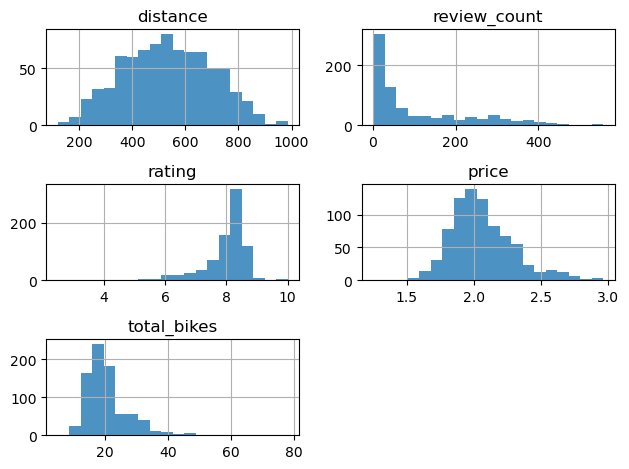

In [26]:
# Histogram of independant variables (all) and dependent variable (total_bikes)
plt.figure(figsize=(12, 8))
merged_yelp[['distance', 'review_count', 'rating', 'price', 'total_bikes']].hist(bins=20, alpha=0.8)
plt.tight_layout()

#### OVERVIEW
- Dependant variable:
    + Total_bikes seems to have some outliers with a lot of bikes compare to the other station
- Independant variables:
    + Distance mean seems pretty well distributed.
    + Review count is totally skewed. Kinf of two categories: under rated and well rated...
    + Rating is almost normally distributed with some outliers near zero.
    + Price mean (taken from mode of each station) seems quite normally distributed.

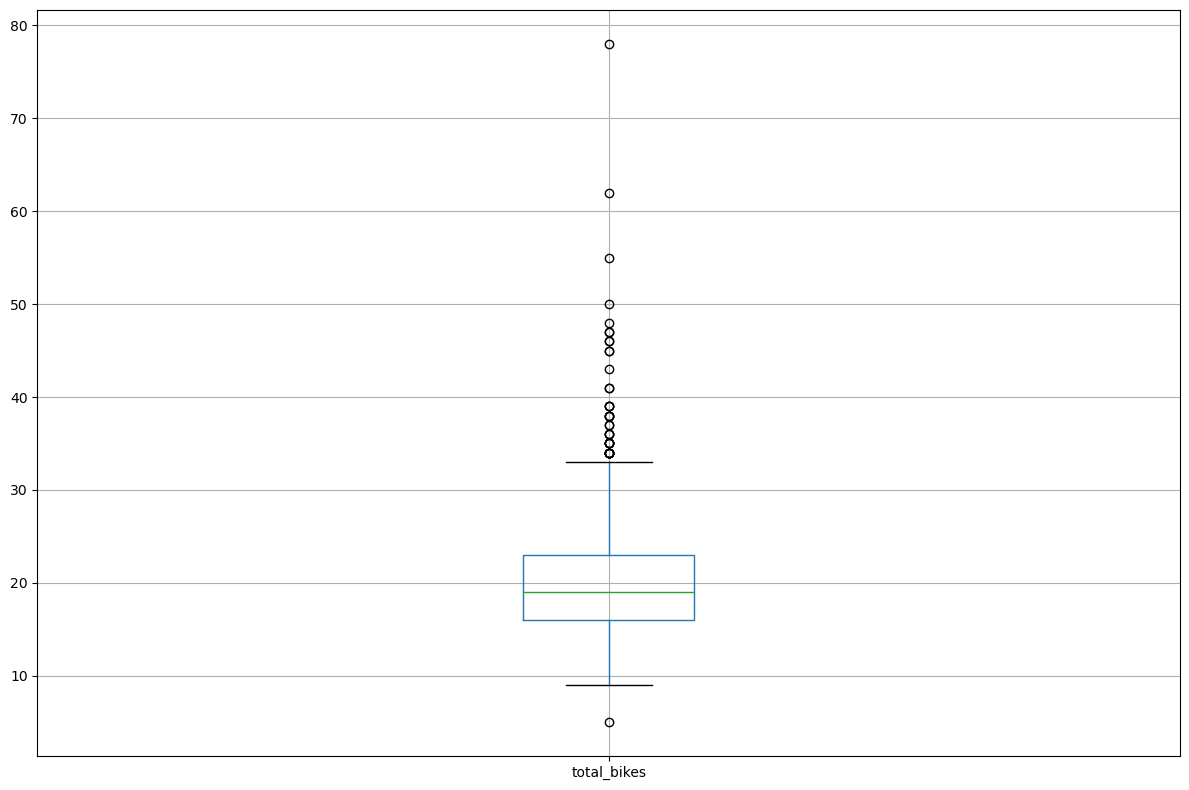

In [29]:
# Validate outliers
plt.figure(figsize=(12, 8))
merged_yelp[['total_bikes']].boxplot()
plt.tight_layout()

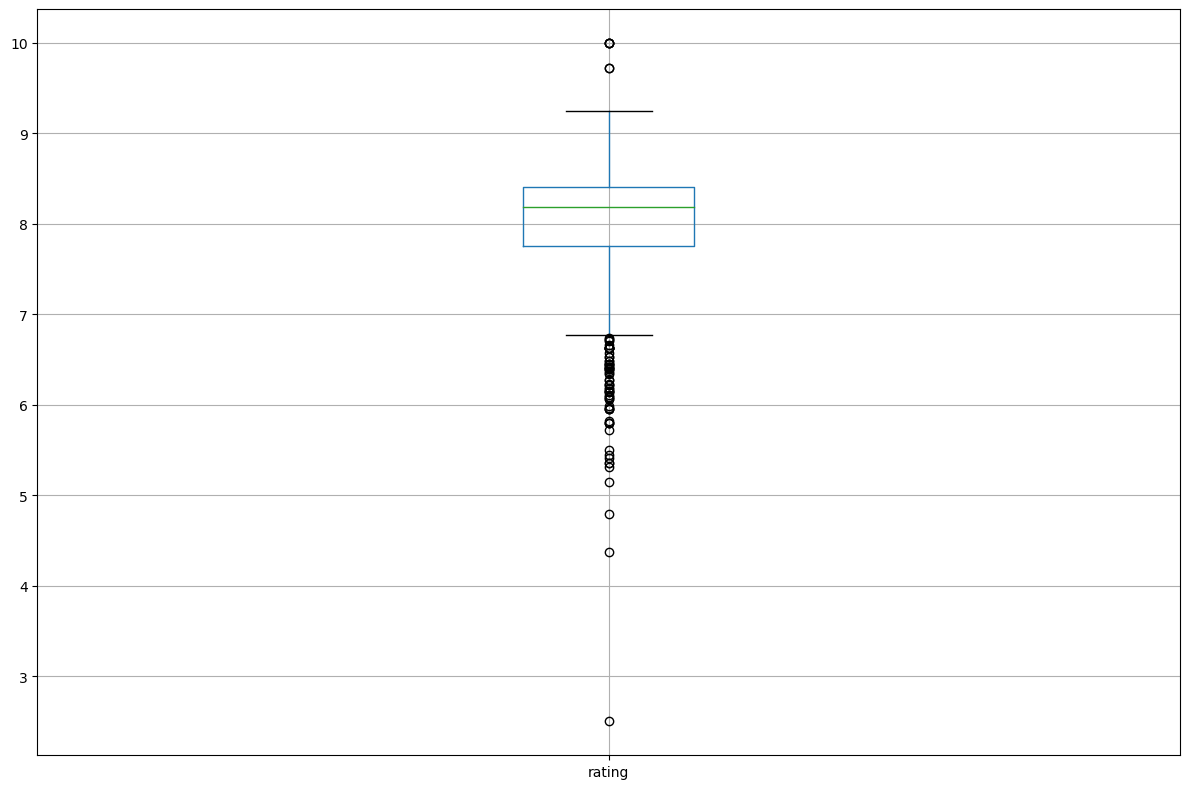

In [30]:
plt.figure(figsize=(12, 8))
merged_yelp[['rating']].boxplot()
plt.tight_layout()

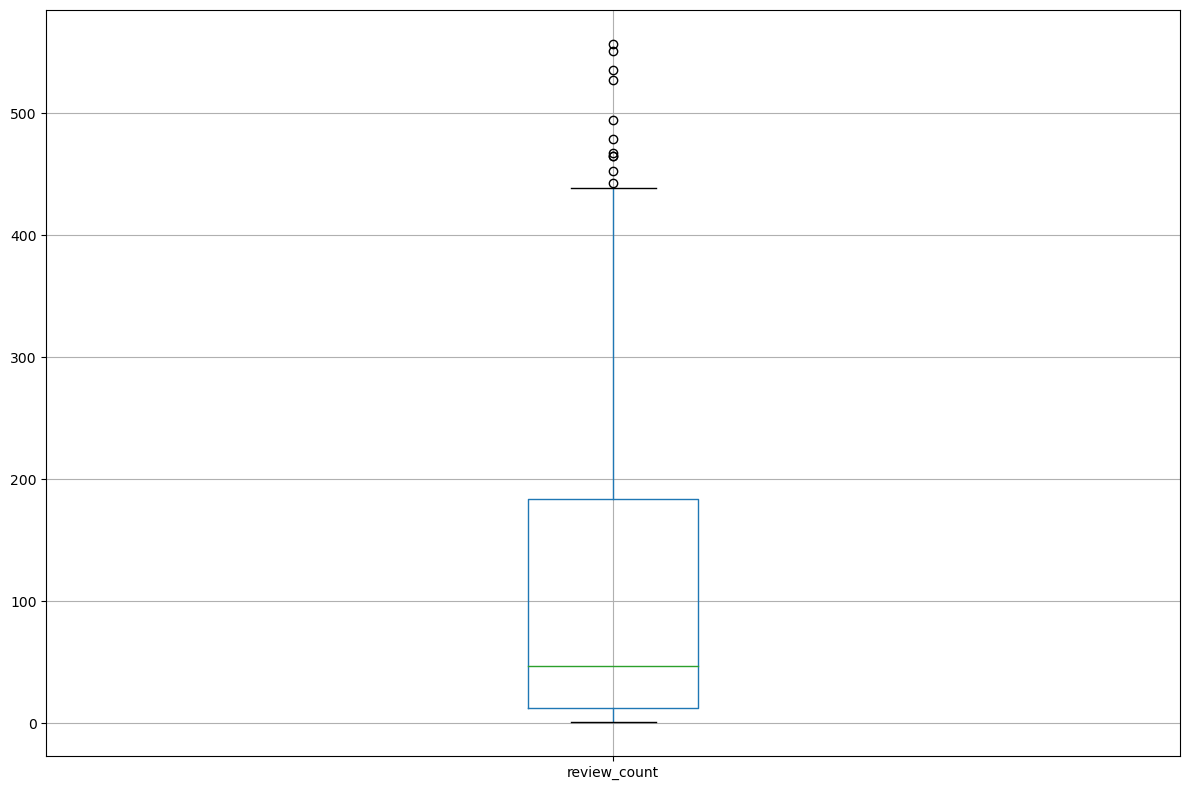

In [31]:
plt.figure(figsize=(12, 8))
merged_yelp[['review_count']].boxplot()
plt.tight_layout()

Considerations for the modeling, we should remove these outliers: 
- Total_bikes below 10 and above 35.
- Rating: all rating below 6, make sense as if their are not 'popular' people won't rent to get their.
- review_count: looks like we should seperate into 2 categories:
    - Not enough review: review_count below 100
    - Enough review: review_count above 100

#### Combined data

In [34]:
merged_df.describe()

,latitude,longitude,total_bikes,station,distance,review_count,rating,popularity,price
count,797.000000,797.000000,797.000000,797.000000,797.000000,795.000000,797.000000,797.000000,797.000000
mean,45.524085,-73.592979,20.877039,398.000000,605.300954,109.460373,7.917227,0.898361,1.568835
std,0.040555,0.048331,6.941242,230.218375,108.337736,125.992256,0.388913,0.046411,0.194149
min,45.416295,-73.758227,5.000000,0.000000,231.073394,1.000000,6.246559,0.647369,1.000000
25%,45.501804,-73.616075,16.000000,199.000000,537.655556,12.355172,7.715135,0.866661,1.424242
50%,45.525194,-73.582596,19.000000,398.000000,611.956897,47.280000,7.989879,0.899922,1.550459
75%,45.545581,-73.565364,23.000000,597.000000,678.710744,183.734023,8.193653,0.936626,1.712000
max,45.702349,-73.436058,78.000000,796.000000,911.351351,556.812500,8.631359,0.970287,2.153226


<Figure size 1200x800 with 0 Axes>

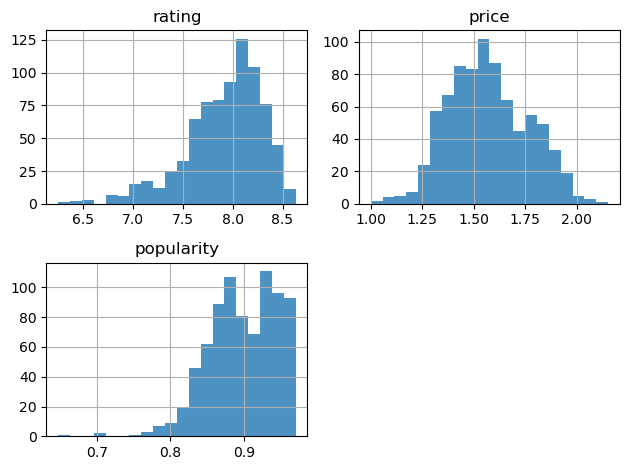

In [38]:
# Histogram of updated independant variables (rating, price, popularity)
plt.figure(figsize=(12, 8))
merged_df[['rating', 'price', 'popularity']].hist(bins=20, alpha=0.8)
plt.tight_layout()

#### OVERVIEW
- We can clearly see a relationship between rating and popularity.
- Rating stil have some outliers but the curves looks more normalized.

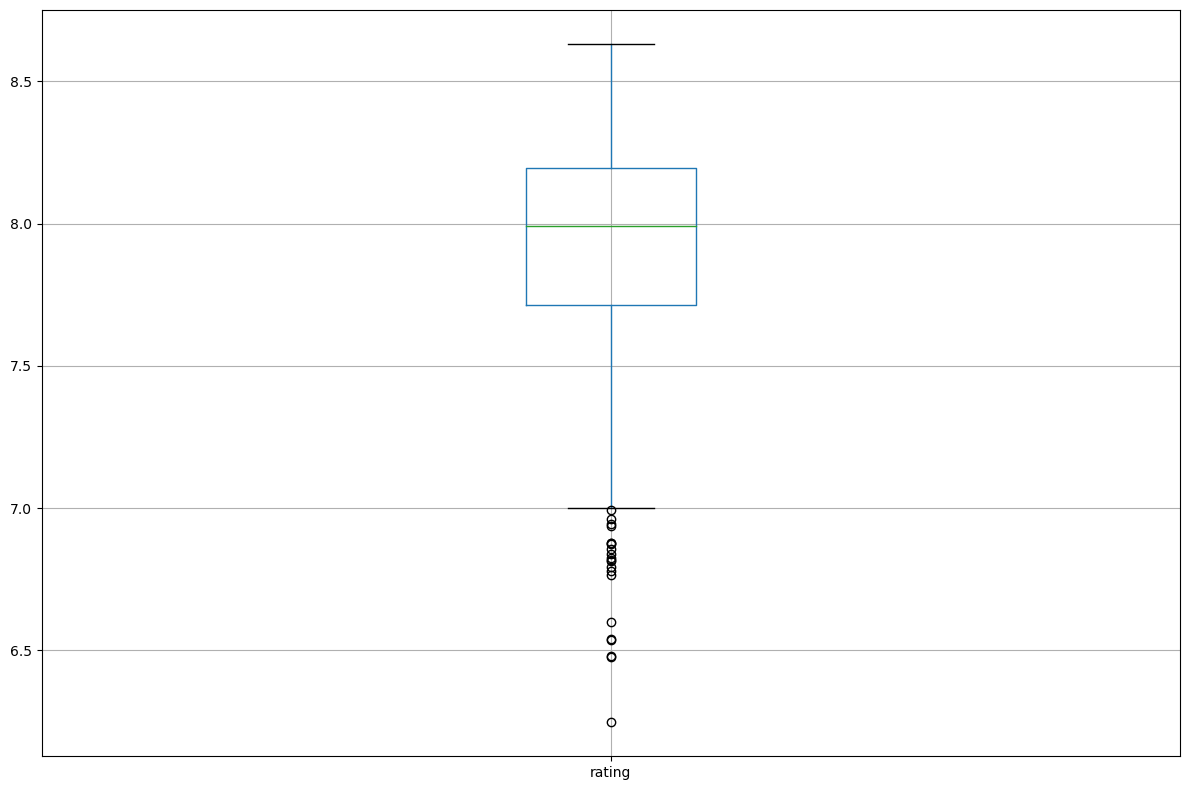

In [39]:
# Validate outliers
plt.figure(figsize=(12, 8))
merged_df[['rating']].boxplot()
plt.tight_layout()

According to this, we should change our consideration for rating to remove outlers with a rating below 7.

### Relationship
It make sense that reviews, rating, popularity should be correlated has it represent the overall perception of the customers.<br>
Maybe price also, lets plot the relationship.

#### Yelp only

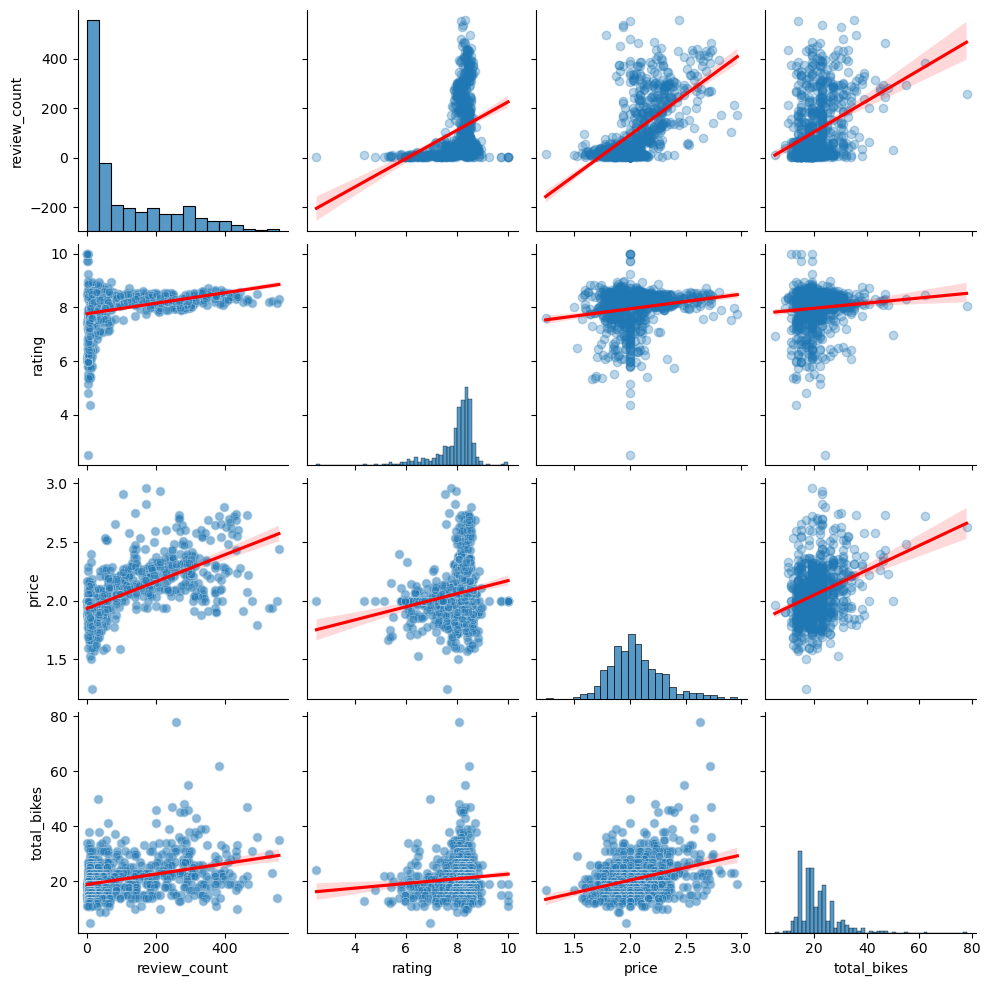

In [41]:
# Visualize relationship with the dependant variable
ind_var = ['review_count', 'rating', 'price']
dep_var = ['total_bikes']

# Create a DataFrame with the variables
vars_to_plot = ind_var + dep_var
data_to_plot = merged_yelp[vars_to_plot]

# Create a pair plot
g = sns.pairplot(data_to_plot, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
g.map_lower(sns.scatterplot, alpha=0.3)

#### Combined data

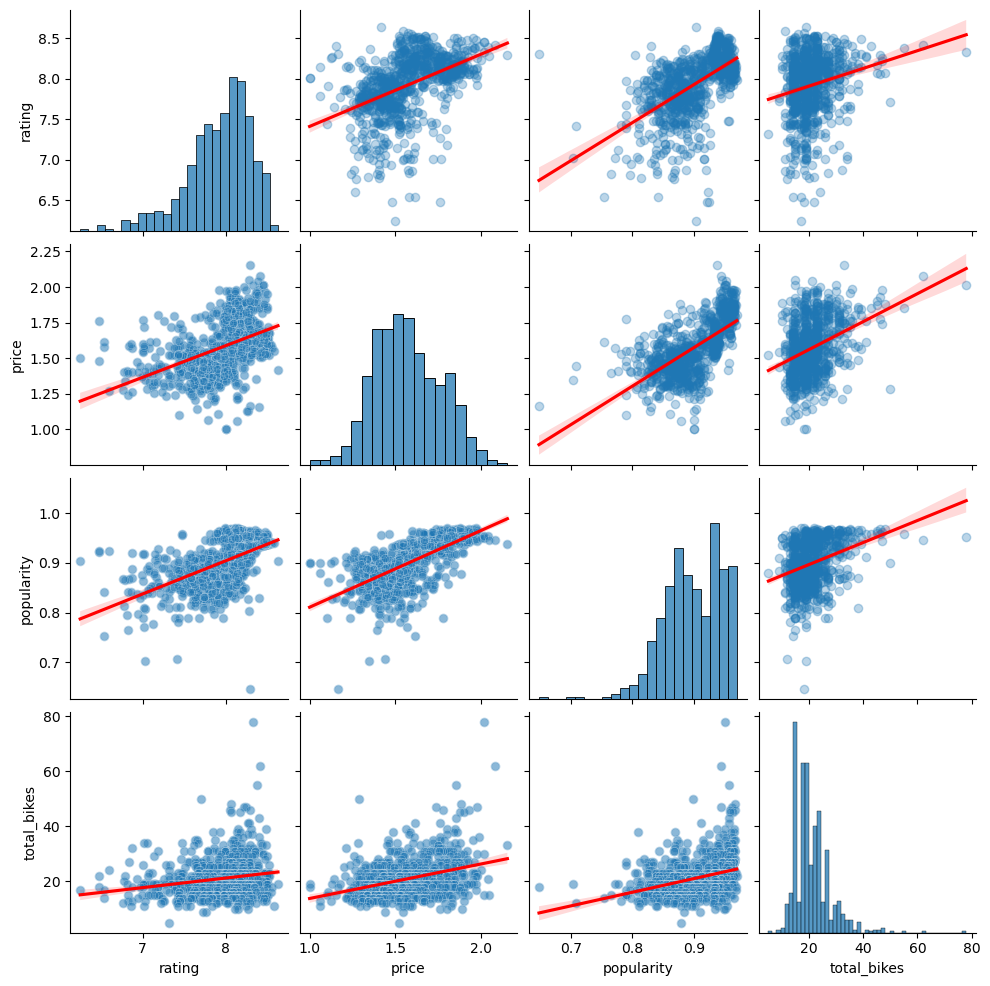

In [43]:
# Visualize relationship with the dependant variable (updated)
ind_var = ['rating', 'price', 'popularity']
dep_var = ['total_bikes']

# Create a DataFrame with the variables
vars_to_plot = ind_var + dep_var
data_to_plot = merged_df[vars_to_plot]

# Create a pair plot
g = sns.pairplot(data_to_plot, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
g.map_lower(sns.scatterplot, alpha=0.3)

#### OVERVIEW
- The only 'visible' relationship between independant variables is the one between rating and price, thought not strong. We could choose either of them for the modelling.
- As for the relationship between 'total_bikes" and all the independant variables, they are all similar, showing a weak positve relationship.


### Correlation

#### Yelp only

Text(0.5, 1.0, 'Correlation Heatmap')

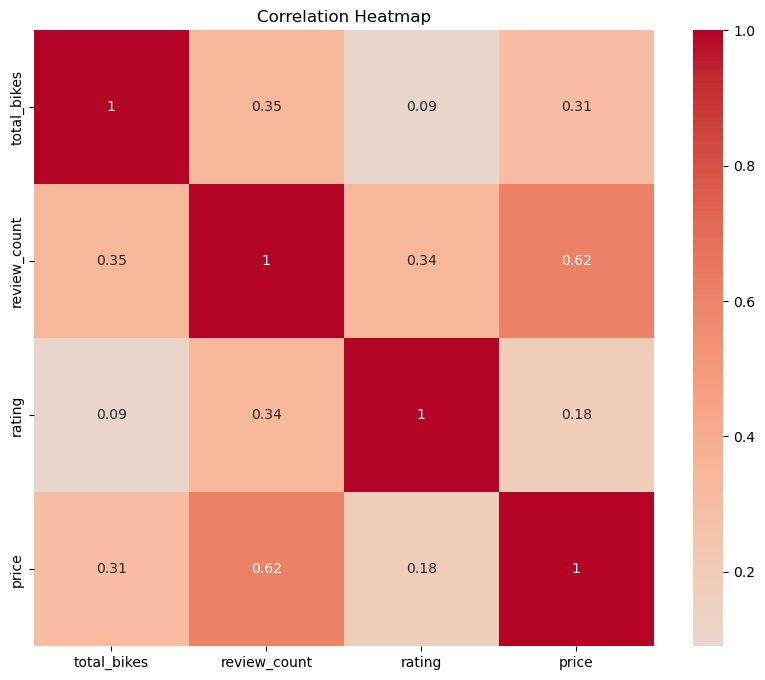

In [44]:
# Correlation
correlation_matrix = merged_yelp[['total_bikes', 'review_count', 'rating', 'price']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')

#### Combined data

Text(0.5, 1.0, 'Correlation Heatmap')

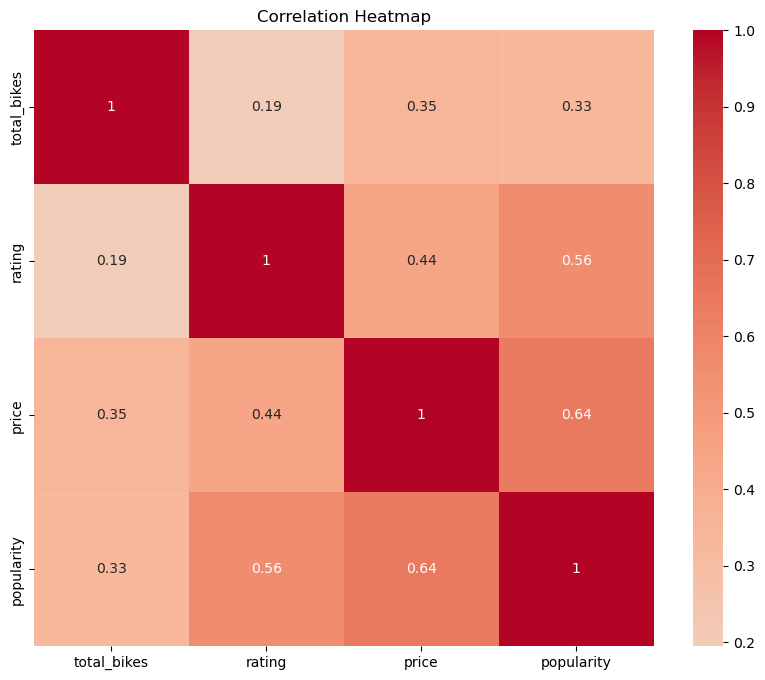

In [46]:
# Correlation
correlation_matrix = merged_df[['total_bikes', 'rating', 'price', 'popularity']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')

#### OVERVIEW
- As expected, price has the strongest correlation with almost all the other varibales.
- Rating as the least correlation with the dependant variable.
- We should use rating for both model and seperate review count into two distinct categories.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

### Creating functions and connection info

In [ ]:
# Connection function
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
# Query function
def execute_query(queries, cursor, data=None, print_message=True):
    try:
        for query in queries:
            if data:
                cursor.execute(query, data)
            else:
                cursor.execute(query)
        
        # Commit only if all statements succeeded
        cursor.connection.commit()
        
        if print_message:
            print("Queries executed successfully")

    except sqlite3.Error as e:
        print("An error occurred:", e)
        # Rollback the transaction in case of error
        cursor.connection.rollback()

### Phase 1a: Create tables<br>
- **stations**: to hold information related to the stations location in the city along with their total bikes
- **pois**: to hold the information about each POI (including rating, popularity, price)
- **categories**: simulates the api category for Foursquare
- **poi_category**: joining table for poi and categories (many-to-many)
- **prices**: to holds the definition of the prices number
- **poi_detail**: creates the relation between data (station, poi_id, distance to the station)

In [ ]:
# CREATE TABLE queries in related order
create_table_queries = [
"""
CREATE TABLE IF NOT EXISTS stations (
  station_id INTEGER PRIMARY KEY AUTOINCREMENT,
  station_name VARCHAR NOT NULL,
  s_lat FLOAT NOT NULL,
  s_lon FLOAT NOT NULL,
  total_bikes INTEGER NOT NULL
);
""",
"""
CREATE TABLE IF NOT EXISTS categories (
  category_id INTEGER PRIMARY KEY,
  category_name VARCHAR NOT NULL
);
""",
"""
CREATE TABLE IF NOT EXISTS prices (
  price INTEGER PRIMARY KEY,
  price_name VARCHAR NOT NULL
);
""",
"""
CREATE TABLE IF NOT EXISTS pois (
  poi_id INTEGER PRIMARY KEY AUTOINCREMENT,
  api_number VARCHAR NOT NULL,
  api_name VARCHAR NOT NULL,
  poi_name VARCHAR NOT NULL,
  p_lat FLOAT NOT NULL,
  p_lon FLOAT NOT NULL,
  rating INTEGER,
  popularity FLOAT,
  price INTEGER,
  FOREIGN KEY (price) REFERENCES prices(price)
);
""",
"""
CREATE TABLE IF NOT EXISTS poi_category (
  poi_id INTEGER NOT NULL,
  category_id INTEGER NOT NULL,
  PRIMARY KEY (poi_id, category_id),
  FOREIGN KEY (poi_id) REFERENCES pois(poi_id),
  FOREIGN KEY (category_id) REFERENCES categories(category_id)
);
""",
"""
CREATE TABLE IF NOT EXISTS poi_detail (
  data_id INTEGER PRIMARY KEY AUTOINCREMENT,
  station_id INTEGER NOT NULL,
  poi_id INTEGER NOT NULL,
  to_station_m INTEGER NOT NULL,
  FOREIGN KEY (station_id) REFERENCES stations(station_id),
  FOREIGN KEY (poi_id) REFERENCES pois(poi_id)
);
"""
]

In [ ]:
# Create connection and cursor
conn = create_connection('../data/mtl_bike_rentals.sqlite')
# Create cursor
cursor = conn.cursor()

In [ ]:
# Call the function to create the tables
execute_query(create_table_queries, cursor)

### Phase 1b: Inserts data in tables

In [ ]:
# Define a function to execute inserts
def execute_inserts(table, query, cursor):

    # Convert DataFrame rows to list of dictionaries
    my_list = table.to_dict(orient='records')

    # Iterate through the list of dictionaries and insert data
    for row in my_list:
        try:
            execute_query(query, cursor, row, print_message=False)

        except sqlite3.Error as e:
            print("An error occurred:", e)
            
    print("Queries executed successfully")

#### Stations table

In [ ]:
# Create query
insert_stations = [
"""
INSERT INTO
  stations (station_id, station_name, s_lat, s_lon, total_bikes)
VALUES
  (:station, :station_name, :latitude, :longitude, :total_bikes);
"""
]

# Insert in table
execute_inserts(stations, insert_stations, cursor)

#### Categories table

In [ ]:
# Create data
categories = (
    fsq_pois[['category_id', 'category_name']]
    .drop_duplicates(subset='category_id')
    .sort_values('category_id')
    .reset_index(drop=True)
)

categories.head()

In [ ]:
# Create query
insert_categories = [
"""
INSERT INTO
  categories (category_id, category_name)
VALUES
  (:category_id, :category_name);
"""
]

# Insert in table
execute_inserts(categories, insert_categories, cursor)

#### Price table

In [ ]:
# Create table

price = {
    1: 'Cheap',
    2: 'Moderate',
    3: 'Expensive',
    4: 'Very Expensive',
}
prices = pd.DataFrame({'price': list(price.keys()), 'price_name': list(price.values())})
prices

In [ ]:
# Create query
insert_prices = [
"""
INSERT INTO
  prices (price, price_name)
VALUES
  (:price, :price_name);
"""
]

# Insert in table
execute_inserts(prices, insert_prices, cursor)

#### POIs table

In [ ]:
# Create table

pois = (
    fsq_pois[['fsq_id', 'name', 'p_lat', 'p_lon', 'rating', 'popularity', 'price']]
    .drop_duplicates(subset='fsq_id')
    .reset_index(drop=True)
)

api_name = 'FourSquare'
pois.insert(loc=1, column='api_name', value=api_name)

pois.head()

In [ ]:
# Save the relation between the index and the fsq_id (for the category_poi table later)

poi_pk = pois[['fsq_id']].copy()
poi_pk['index_number'] = pois.index

poi_pk.head()

In [ ]:
# Create query

insert_pois = [
"""
INSERT INTO
  pois (api_number, api_name, poi_name, p_lat, p_lon, rating, popularity, price)
VALUES
  (:fsq_id, :api_name, :name, :p_lat, :p_lon, :rating, :popularity, :price);
"""
]

# Insert in table
execute_inserts(pois, insert_pois, cursor)

#### POI_category table

In [ ]:
# Create table
fsq_cat = fsq_pois[['fsq_id', 'category_id']]

poi_category = fsq_cat.merge(poi_pk, on='fsq_id', how='left') # poi_pk created in previous query
poi_category.drop(columns='fsq_id', inplace=True)

poi_category.head()

In [ ]:
# Create query
insert_poi_category = [
"""
INSERT INTO
  poi_category (poi_id, category_id)
VALUES
  (:index_number, :category_id);
"""
]

# Insert in table
execute_inserts(poi_category, insert_poi_category, cursor)

#### POI_detail

In [ ]:
# Create table

poi_detail = fsq_pois[['station', 'distance', 'fsq_id']].drop_duplicates()
poi_detail = poi_detail.merge(poi_pk, on='fsq_id', how='left')
poi_detail.drop(columns='fsq_id', inplace=True)

poi_detail.head()

In [ ]:
# Create query

insert_poi_detail = [
"""
INSERT INTO
  poi_detail (station_id, poi_id, to_station_m)
VALUES
  (:station, :index_number, :distance);
"""
]

# Insert in table
execute_inserts(poi_detail, insert_poi_detail, cursor)

In [ ]:
# Close the cursor and connection
cursor.close()
conn.close()

### Phase 2: Read data

Look at the data before and after the join to validate your data.

In [ ]:
# create connection
conn = sqlite3.connect('../data/mtl_bike_rentals.sqlite')

In [ ]:
# all data from db
df_all = pd.read_sql(
    """
    SELECT 
        name
    FROM
        sqlite_master 
    WHERE
        type ='table'
        AND name NOT LIKE 'sqlite_%';
    """, conn
)

# Print the DataFrame
print(df_all)

In [ ]:
# Select data for modeling and compare values to bike.rentals_csv (dataframe)

df_rentals = pd.read_sql(
    """
    SELECT
        s.station_name AS name,
        s.station_id AS station,
        AVG(s.total_bikes) as total_bikes,
        AVG(pd.to_station_m) AS avg_distance_to_station_m,
        AVG(p.rating) AS avg_rating,
        AVG(p.popularity) AS avg_popularity,
        AVG(p.price) AS avg_price
    FROM
        stations s
    JOIN poi_detail pd USING(station_id)
    JOIN pois p USING(poi_id)
    JOIN poi_category USING(poi_id)
    JOIN categories c USING(category_id)
    GROUP BY 1, 2
    HAVING
        total_bikes BETWEEN 10 AND 50
        AND avg_rating >= 6
        AND avg_price <=2
        AND avg_distance_to_station_m > 1000
    ORDER BY 2
    """, conn
)

print(df_rentals)

In [ ]:
df_rentals.describe()

In [ ]:
# Select data for modeling and compare values to bike.rentals_csv (dataframe)

df_stations = pd.read_sql(
    """
    SELECT station_id, poi_id, to_station_m
    FROM
        poi_detail pd
    WHERE
        to_station_m > 10000
    """, conn
)

print(df_stations)